In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # traçage de graphiques
import numpy as np # traitement des arrays numériques
import pandas as pd

from sklearn import datasets # datasets classiques
from sklearn import preprocessing # normalisation les données
from sklearn import decomposition # PCA et NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

np.random.seed = 2017 # pour des résultats reproductibles

# 0. Motivations
On peut souhaiter réduire de nombre de dimensions d'un jeu de données :
- pour le compresser et diminuer le volume d'informations utiles à stocker et par la même occasion la durée d'exécution d'un algorithme d'apprentisssage (car l'espace à explorer est plus petit)
- pour n'en conserver que les caractéristiques (features) discriminantes et éviter ainsi le surapprentissage (apprentissage du bruit dans les données)

# 1. PCA - L'analyse en composantes principales

## 1.1 Algorithme
**L'analyse en composantes principales pour des données numériques en n dimensions est un algorithme non supervisé d'identification des dimensions de variance décroissante et de projection pour ne conserver que les k dimensions de plus grande variance.**

Elle peut typiquement être utile pour identifier des dimensions qui seraient des combinaisons linéaires d'autres dimensions (plus un léger bruit), ou à minima très fortement corrélée, et les filtrer de notre espace d'observation. Par exemple, si on souhaite prédire des prix immobilier en fonction de la superficie de l'appartement, du nombre de pièces, de la présence d'universités/parcs/commerces à proximité et de la criminalité dans le quartier. On peut s'attendre à ce que nos 2 premières et 2 dernières dimensions soient fortement corrélées : une ACP en 2 dimensions révélera sans doute une dimension liée à la taille du bien et une autre à la qualité de vie dans le quartier.

Nous verrons cependant que dans un objectif de classification, rien ne garantit que les dimensions de grande variance soient les plus utiles et qu'il faut faire preuve de vigilance.

L'algorithme consiste à :

0. *Optionnel : Normaliser les données (important si les données n'ont par exemple pas été mesurées aux mêmes échelles)*
0. Construire la matrice de corrélation (covariance si on a centré les données) entre les variables :
$\Sigma = \frac{1}{n-1}\sum_{i=1}^{n}{((X - \bar{x})'(X - \bar{x}))}$
0. Trouver les valeurs propres $\lambda_i$ et vecteurs propres $v_i$ :
$\Sigma v_i = \lambda_iv_i$, ces vecteurs propres forment un repère orthogonal de l'espace des données (en tant que vecteurs propres d'une matrice symmétrique qu'on supposera de rang n)
0. Classer les valeurs propres (et les vecteurs associés) de façon décroissante : $\{\lambda_{(n)}, \lambda_{(n-1)}...\lambda_{(1)} \}$ où $\lambda_{(i)}$ est la i-ème variance dans l'ordre croissant
0. Ne conserver que les k  ($k \leqslant n$)  premiers vecteurs : $\{v_{(n)}, v_{(n-1)}...v_{(n-k+1)} \}$
0. Construire la matrice de projection dans l'espace de ces vecteurs (changement de base si n=k)
$$
\begin{bmatrix}
\lambda_{(1)1} & \dots  & \lambda_{(n)1} \\
\vdots         & \ddots & \vdots \\
\lambda_{(1)k} & \dots  & \lambda_{(n)k} \\
\end{bmatrix}
$$
0. Projeter les données initiales dans cet espace de dimension k
![Illustration PCA](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png)

Cas particuliers :
* la matrice de covariance est de rang r < n (certaines dimensions sont des combinaisons linéaires exactes d'autres dimensions) : on ne pourra extraire au maximum que le nombre de vecteurs propres égal au rang de la matrice et une projection sur l'espace de ces r vecteurs propres se fera sans perte d'information.
* plusieurs covariances sonts de même valeur : plusieurs décompositions équivalentes existent

** Cet algorithme est le plus intuitif mais on lui préfère souvent une [décomposation en valeurs singulières](https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res) : unméthode d'algèbre linéaire généraliste de factorisation de matrices plus efficace numériquement que la diagonalisation requise pour trouver les vecteurs propres de $\Sigma$. Cette méthode s'implémente directement avec [Numpy](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html).** Une variante [Kernel-PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis) permet également de décomposer l'espace après des tranformations non linéaires (si on observe par exemple qu'une classe en entoure une autre dans certaines dimensions).

Cf. :
* Principe général : https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales 
* Implémentation SKL : http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* Un refresh sur les vecteurs propres si nécessaire : https://www.youtube.com/watch?v=PFDu9oVAE-g

## 1.2 Implémentation avec scikit-learn
Tout cela peut bien sur être implémenté from scratch avec Numpy mais nous utiliserons ici scikit-learn pour raccourcir l'implémentation et nous concentrer sur la visualisation des résultats.
### 1.2.1 Données
Nous partirons classiquement du dataset Iris (classification entre 3 fleurs sur la base de 4 mesures) :

In [2]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

Dimensions de l'espace de départ : 4
Représentation des données dans ces dimensions :


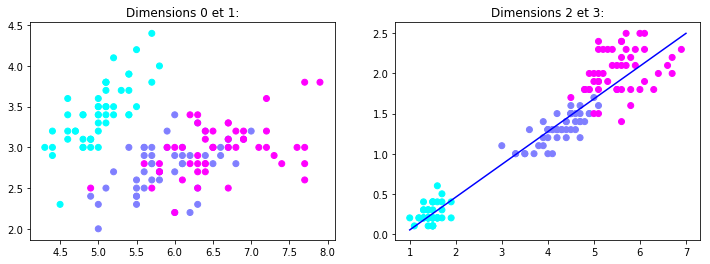

In [3]:
print("Dimensions de l'espace de départ : {}".format(X_iris.shape[1]))
print("Représentation des données dans ces dimensions :")

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) # on affiche les graphes côte à côte (1 ligne de 2 graphes) et le prochain graphe est le 1er 
plt.title("Dimensions 0 et 1:")
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=plt.cm.cool) # on utilise les labels pour définir la couleur de chaque point
plt.subplot(1, 2, 2) # 2nd graphe de notre ligne
plt.title("Dimensions 2 et 3:")
plt.scatter(X_iris[:, 2], X_iris[:, 3], c=y_iris, cmap=plt.cm.cool)
plt.plot([1,7],[0.05,2.5], c='b')
plt.show()

### 1.2.2 Premier exemple de PCA
Graphiquement, on peut se dire que les 2 dernières dimensions sont très corrélées et donc redondantes. Dans un strict but de classification, on pourrait d'ailleurs presque se contenter de la dimension indiquée par la ligne bleue pour correctement discriminer les 3 types de fleurs (*nous verrons par la suite qu'il s'agit d'un cas particulier non généralisable*).

Effectuons une PCA avec scikit-learn avec un changement de base conservant les 4 dimensions pour illustrer leurs différences :

In [4]:
# Gardons toutes les composantes pour le moment
# Nous pourrons toujours en retirer ensuite puisqu'elles seront triées par significativité
pca = decomposition.PCA(n_components=4)

X_iris_PCA = pca.fit(X_iris).transform(X_iris) 

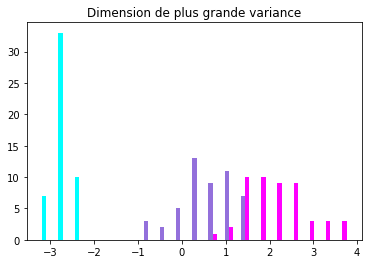

In [5]:
X_stack = np.array([X_iris_PCA[y_iris==0, 0], X_iris_PCA[y_iris==1, 0], X_iris_PCA[y_iris==2, 0]]).T
plt.hist(X_stack,
         bins=np.linspace(X_stack.min(), X_stack.max(), 20),
         color=['cyan', 'mediumpurple', 'magenta'])
plt.title('Dimension de plus grande variance')
plt.show()

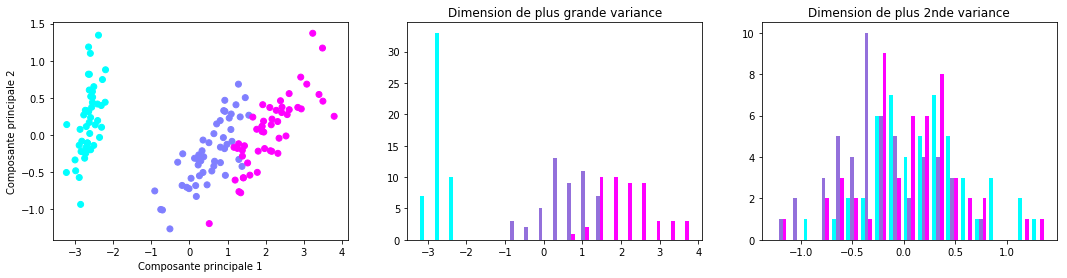

In [6]:
def graph_acp3(X_PC, y):
    plt.figure(figsize=(18,4))
    
    plt.subplot(1, 3, 1)
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.scatter(X_PC[:, 0], X_PC[:, 1], c=y, cmap=plt.cm.cool)
    
    plt.subplot(1, 3, 2)
    X_stack = np.array([X_PC[y==0, 0], X_PC[y==1, 0], X_PC[y==2, 0]]).T
    plt.hist(X_stack,
             bins=np.linspace(X_stack.min(), X_stack.max(), 20),
             color=['cyan', 'mediumpurple', 'magenta'])
    plt.title('Dimension de plus grande variance')

    plt.subplot(1, 3, 3)
    X_stack = np.array([X_PC[y==0, 1], X_PC[y==1, 1], X_PC[y==2, 1]]).T
    plt.hist(X_stack,
             bins=np.linspace(X_stack.min(), X_stack.max(), 20),
             color=['cyan', 'mediumpurple', 'magenta'])
    plt.title('Dimension de plus 2nde variance')
    
    plt.show()

graph_acp3(X_iris_PCA, y_iris)

## 1.3 Quelques réserves
Comme évoqué dans la présentation, il est à noter qu'il s'agit d'un **algorithme non supervisé**, qui ne tient donc pas compte des étiquettes des données.
Dans le cas ci-dessus, nous avons eu la chance que les données soient linéairement séparables sur la dimension de plus grande variance. Dans le cas contraire, l'ACP aurait pu ne pas nous aider et nous aurions même pu perdre les dimensions selon lesquelles discriminer les données correctement.

A noter également que dans le cas de données de variance assez homogène selon toutes les dimensions, une ACP ne nous apporte rien.

**L'ACP peut donc être inutile voire contreproductive dans un objectif de classification.**

Ci-après 2 contre-exemples :

### 1.3.1 ACP et discrimination selon dimension de moindre variance

In [7]:
def graph_acp2(X_PC, y):
    plt.figure(figsize=(18,4))
    
    plt.subplot(1, 3, 1)
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.scatter(X_PC[:, 0], X_PC[:, 1], c=y, cmap=plt.cm.cool)
    
    plt.subplot(1, 3, 2)
    X_stack = np.array([X_PC[y==0, 0], X_PC[y==1, 0]]).T
    plt.hist(X_stack,
             bins=np.linspace(X_stack.min(), X_stack.max(), 20),
             color=['cyan', 'magenta'])
    plt.title('Dimension de plus grande variance')

    plt.subplot(1, 3, 3)
    X_stack = np.array([X_PC[y==0, 1], X_PC[y==1, 1]]).T
    plt.hist(X_stack,
             bins=np.linspace(X_stack.min(), X_stack.max(), 20),
             color=['cyan', 'magenta'])
    plt.title('Dimension de plus 2nde variance')
    
    plt.show()

In [8]:
X11 = np.random.rand(30)*10
X21_bruit = np.random.rand(30) * 0.5
X21 = X11 + 1 + X21_bruit
X12 = np.random.rand(30)*10
X22_bruit = np.random.rand(30) * 0.7
X22 = X12 + 2 + X22_bruit
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(30), np.ones(30)))
X = preprocessing.scale(X, with_mean=True, with_std=True)

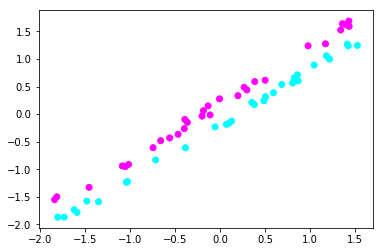

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.cool)
plt.show()

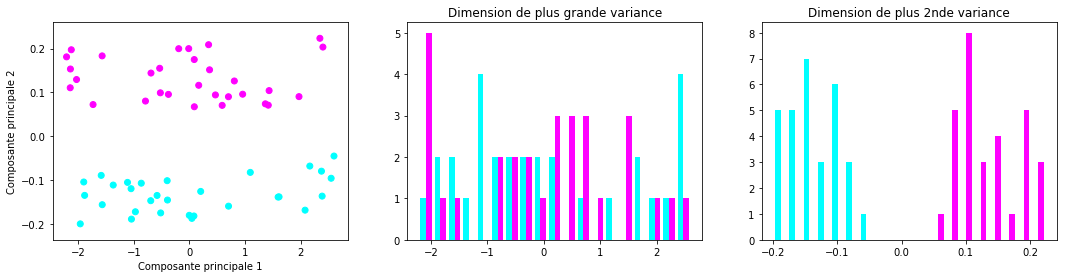

In [10]:
pca = decomposition.PCA(n_components=2)
X_PC2 = pca.fit(X).transform(X)
graph_acp2(X_PC2, y)

Ici une ACP ne retenant que la dimension de plus grande variance nous aurait donc fait perdre toute possibilité de discrimination. Pour s'en rendre compte, il suffit d'observer qu'en composantes principales on obtient des répartitions étirées et parallèles des classes.

### 1.3.2 ACP sur des données de variance homogène

In [11]:
X11 = np.random.normal(0, 10, 500)
X21 = abs(np.random.normal(0, 10, 500))
X12 = np.random.normal(0, 10, 500)
X22 = -abs(np.random.normal(0, 10, 500))
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(500), np.ones(500)))
y = y.astype(int)

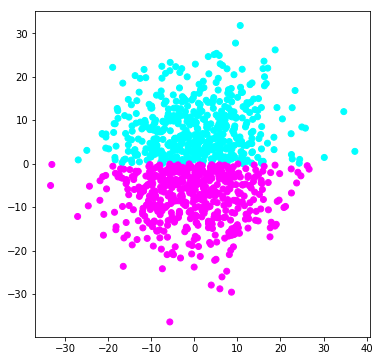

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.cool)
plt.show()

In [13]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_PC2 = pca.transform(X)

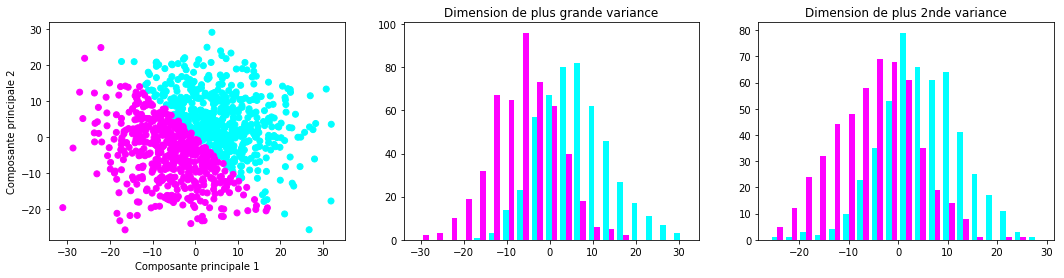

In [14]:
graph_acp2(X_PC2, y)    

Ici une ACP est inutile car la variance des données est homogène selon les dimensions initiales. Pour s'en rendre compte a priori, il suffit d'observer que les 2 valeurs propres de la matrice de covariance sont très proches.

# 2. Autres méthodes
D'autres méthodes, que nous détaillerons moins pour le moment, peuvent être plus pertinentes que l'ACP dans certains contextes :

## 2.1 L'[analyse discriminante linéaire ou quadratique](http://scikit-learn.org/stable/modules/lda_qda.html) (LDA/QDA)
Plutôt que de maximiser la variance sur des dimensions des données, on va ici chercher à maximiser la variance inter-classes par rapport à celle intra classe. Cette méthode transformera donc l'espace d'origine en un espace plus adapté que l'ACP dans un objectif de classification.

Rappel des composantes identifiées par le PCA :


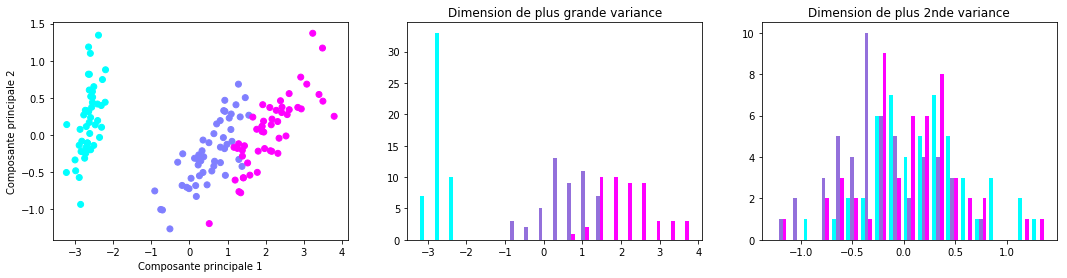

Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :


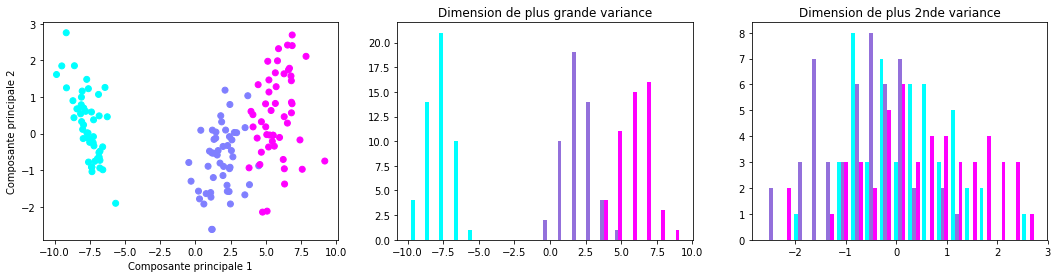

In [15]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_iris_LDA = lda.fit(X_iris, y_iris).transform(X_iris)

print("Rappel des composantes identifiées par le PCA :")
graph_acp3(X_iris_PCA, y_iris) 
print("Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :")
graph_acp3(X_iris_LDA, y_iris) 

## 2.2 La  [Factorisation de matrices non négatives](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
Au delà de la SVD, des algorithmes de factorisation de matrice sont opitmisés pour les matrices ne contenant que des valeurs positives, ce qui permet d'envisager de traiter des matrices de bien plus grande taille (parfois creuses). Sans entrer dans les détails de ces alogithmes, nous allons ici chercher à approcher une matrice positive **V de dimensions m\*n** (e.g. les évaluations de tous les clients d'un site commerçant sur tous les produits) par un **produit d'une matrice W de dimensions m\*k** (e.g. le profils des clients) **avec une matrice H de dimensions k\*n** (e.g. les évaluations moyennes pour ces profils). Nous chercherons ainsi à avoir (m\*k + k\*n) << m\*n pour diminuer l'espace de représentation de nos données, tout en conservant le maximum d'information.

$$
\begin{bmatrix}
    v_{11}       & v_{12} & v_{13} & \dots  & v_{1n} \\
    v_{21}       & v_{22} & v_{23} & \dots  & v_{2n} \\
    v_{31}       & V_{32} & v_{33} & \dots  & v_{3n} \\
    \vdots       & \vdots & \vdots & \ddots & \vdots \\
    v_{m1}       & V_{m2} & v_{m3} & \dots  & v_{mn}
\end{bmatrix}
=
\begin{bmatrix}
    w_{11} & \dots  & w_{1k} \\
    w_{21} & \dots  & w_{2k} \\
    w_{31} & \dots  & w_{3k} \\
    \vdots & \ddots & \vdots \\
    w_{m1} & \dots  & w_{mk}
\end{bmatrix}
*
\begin{bmatrix}
    h_{11} & h_{12} & h_{13} & \dots  & h_{1n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    h_{k1} & h_{k2} & h_{k3} & \dots  & h_{kn}
\end{bmatrix}
$$

Sans entrer dans les détails, ces algorithmes consisteront à trouver W et H qui minimisent $||V - W*H ||_F^2$. Il est  à noter que la solution minimisant cette norme peut ne pas être unique. De plus ces algorithmes sont multiples, souvent de complexité computationnelle élevée et requièrent des régularisations.

A titre d'exemple construisons une matrice de notations de films par des utilisateurs que nous allons tâcher de factoriser en une matrice de profils (les goûts de chaque utilisateurs) et une autre de catégories de films (les profils auxquels ces films sont susceptibles de plaire). Ces notations vont de 1 à 9 et on désignera par 0 l'absence de note. Cet exemple est volontairement simpliste et ne peut pas passer à l'échelle ni être généralisé trivialement.

In [16]:
df = pd.DataFrame.from_dict({'loves_everything': [9,9,9,9,9,9,0],
                             'big_guns':         [1,2,1,8,9,8,9],
                             'testosterone guy': [0,0,1,9,9,9,7],
                             'girlygirl':        [9,0,8,1,0,0,7],
                             'romance_addict':   [9,8,0,0,0,1,0],
                             'machoman':         [0,1,0,8,7,9,8],
                             'loves_flowers':    [7,8,0,0,0,0,8],
                             'easily_pleased':   [0,8,8,0,7,9,7],
                             'chuck_norris_fan': [0,2,0,9,0,9,8],
                             'mylittleponey98':  [7,0,7,0,1,0,8],
                             'allmoviesrock':    [7,8,0,0,7,8,7],
                             'more_guns_please': [0,2,0,9,8,0,7],
                             'yeah_guns666':     [1,0,3,0,9,9,0]},
                           ).transpose()
df.index.name = "Users"
df.columns = ['Charming prince', 'First date', 'Lovely love', 'Guns are cool', 'Ultra badass 4', 'My fist in your face', 'Guns & roses']
df.columns.name = "Movies"
df

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
Users,,,,,,,
allmoviesrock,7,8,0,0,7,8,7
big_guns,1,2,1,8,9,8,9
chuck_norris_fan,0,2,0,9,0,9,8
easily_pleased,0,8,8,0,7,9,7
girlygirl,9,0,8,1,0,0,7
loves_everything,9,9,9,9,9,9,0
loves_flowers,7,8,0,0,0,0,8
machoman,0,1,0,8,7,9,8
more_guns_please,0,2,0,9,8,0,7


In [17]:
nmf = decomposition.NMF(n_components=2,
                        random_state=1,
                        alpha=.1,
                        l1_ratio=.5).fit(df)

In [18]:
profiles = pd.DataFrame(nmf.transform(df),
                        index=df.index, 
                        columns=['action lover', 'romcom lover'])
profiles.columns.name = 'Categories'
profiles

Categories,action lover,romcom lover
Users,,
allmoviesrock,1.364464,1.788403
big_guns,2.542310,0.229329
chuck_norris_fan,1.945916,0.072006
easily_pleased,1.649300,1.397724
girlygirl,0.031053,2.159935
loves_everything,1.847780,2.263489
loves_flowers,0.092489,2.079689
machoman,2.436259,0.000000
more_guns_please,1.755344,0.047097


In [19]:
profiles = profiles > 1
profiles

Categories,action lover,romcom lover
Users,,
allmoviesrock,True,True
big_guns,True,False
chuck_norris_fan,True,False
easily_pleased,True,True
girlygirl,False,True
loves_everything,True,True
loves_flowers,False,True
machoman,True,False
more_guns_please,True,False


In [20]:
movie_cat = pd.DataFrame(nmf.components_,
                         columns=df.columns,
                         index=['action lover', 'romcom lover'])
movie_cat.index.name = 'Categories'
movie_cat = movie_cat > 1

In [21]:
movie_cat

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
Categories,,,,,,,
action lover,False,False,False,True,True,True,True
romcom lover,True,True,True,False,False,False,True


Nous avons donc bien obtenu une matrice de profils et une autre de catégories de films dont la multiplication nous donnera approximativement les goûts des utilisateurs pour chaque film, y compris ceux qu'ils n'ont pas vus ou évalués.

*Auteur : R. Menuet*